In [1]:
import sys
sys.path.append('/workdir/sj657/lymph_node/for_public/software/BLAZE')
import blaze.polyT_adaptor_finder as polyT_adaptor_finder
#from blaze.polyT_adaptor_finder import find_poly_T
from blaze.main import get_raw_bc_from_reads
from blaze.main import read_batch_generator
import shlex
import os
import getopt
from collections import defaultdict, Counter
from tqdm import tqdm
import multiprocessing as mp
import textwrap
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import zipfile
import io
import logging
import gzip
import blaze.helper as helper
# from blaze.config import *
import blaze.config as config
from collections import namedtuple
from fast_edit_distance import sub_edit_distance # significantly improved running time compared with Lev distance

In [1]:
# sc.settings.verbosity = 0
pd.set_option('display.max_columns', 50)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 100)
# sc.settings.n_jobs=10

NameError: name 'pd' is not defined

# Step 1

In [4]:
fn = "/workdir/sj657/lymph_node/for_public/codes/github_pub/output_files/R2C2_output/allTP_ONT_concensus.fastq"
# load the reads; read the whold fastq files
# read_tuple = namedtuple('read_tuple', ['id', 'seq', 'q_letter'])
read_dict = {}
with open(fn, "r") as handle:
    while True:
        id = next(handle, None)
        if id is None:
            break
        seq = next(handle)
        next(handle) # skip  '+'
        q_letter = next(handle)
        id = id[1:].split()[0]
        seq = seq.strip()
        q_letter = q_letter.strip()
        read_dict[id] = [seq, q_letter]
process_read_list = []
for id,value in read_dict.items():
    try:
        # print(id)
        read = polyT_adaptor_finder.Read(read_id = id, sequence=str(value[0]), 
                        phred_score=value[1]) # the method allow
        read.get_strand_and_raw_bc()
        read.putative_UMI
        process_read_list.append(read.__dict__)
    except Exception as e:
        print(f"Error processing id {id}: {e}")
    # break
process_read_df = pd.DataFrame(process_read_list)

In [7]:
# filter
process_read_df = process_read_df[process_read_df['adaptor_polyT_pass']==0]
process_read_df = process_read_df[process_read_df['_strand']=="+"]
# filter the ones without BC1 or BC2
process_read_df = process_read_df[process_read_df['raw_bc2']!='']
process_read_df.shape
process_read_df = process_read_df[process_read_df['raw_bc1']!='']
process_read_df.shape

In [12]:
process_read_df['Barcode'] = process_read_df['raw_bc1'] + process_read_df['raw_bc2']
# save
process_read_df.to_pickle("../output_files/objects/AllTP_ONT_filtered_reads_process.pkl")

# Step 2

In [20]:
from fast_edit_distance import edit_distance, sub_edit_distance
import blaze.polyT_adaptor_finder as polyT_adaptor_finder
#from blaze.polyT_adaptor_finder import find_poly_T
from blaze.main import get_raw_bc_from_reads
from blaze.main import read_batch_generator
import multiprocessing as mp
import tempfile
import pandas as pd
import numpy as np
import gzip
import os
# from tqdm import tqdm
import logging
import sys
from io import StringIO
import io
import gzip
import glob

import blaze.helper as helper
from blaze.config import *
from multiprocessing import Pool, cpu_count
import time

In [14]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [15]:
# read all fasta file
def fasta_todf(input_file,tp):
    full_dict = {}
    names = []
    seqlr = []
    with open(input_file, "r") as infile:
        seq = ""
        header = ""
        for line in infile:
            if line.startswith(">"):
                header = line.strip()
                names.append(header)
            else:
                seq = line.strip()
    full_dict['read_name'] = names
    full_dict['Sample'] = tp
    return pd.DataFrame.from_dict(full_dict)


dfs = []
for i in ['Mock','D3','D7','D10','D14','D21']:
    print(i)
    tmp_read_df = fasta_todf("/workdir/sj657/lymph_node/for_public/codes/github_pub/output_files/R2C2_output/"+i+"_ONT_concensus.fasta",tp = i)
    dfs.append(tmp_read_df)
all_read_df = pd.concat(dfs)

Mock
D3
D7
D10
D14
D21


In [17]:
# merge
process_read_df = process_read_df.merge(all_read_df, how = "left", left_on="id",right_on = "read_name")
process_read_df.shape

(1595948, 18)

In [18]:
process_read_df.Sample.value_counts()

Sample
D10     494853
D14     262143
D3      241149
D7      221445
D21     219255
Mock    157103
Name: count, dtype: int64

In [ ]:
for tp in ["Mock","D3","D7","D10","D14","D21"]:
    path = "../slideseq_beadbarcodes/"+tp+"_BeadBarcodes.txt"
    inf_barcode = pd.read_csv(glob.glob(path)[0], delimiter="\t", names= ["barcode", "x", "y"])
    white_bb = set(inf_barcode['barcode'])
    print(len(white_bb))
    from multiprocessing import Pool, cpu_count
    def match_bc_row(bc,whitelist=white_bb, max_ed = 2):
        best_ed = []
        bc_hit = []
        bc_hit_end_idx = -1
        ambiguous_or_not = 'not'
        # extending the putative barcode from both sides for potential indels
        # bc = row.pre_bc_flanking[-DEFAULT_ED_FLANKING:] + bc + row.putative_umi[:DEFAULT_ED_FLANKING]
        for i in whitelist:
            #print(i)
            ed, end_idx = sub_edit_distance(i, bc, max_ed) 
            #print(ed,end_idx)
            if ed == 0:
                #print("Found exact match")
                best_ed = [ed]
                bc_hit = [i]
                break
            elif ed <= 2:
                bc_hit.append(i)
                best_ed.append(ed)
    
        # check the list and only keep the one if it contains 1
        if 1 in best_ed:
            # keep the ones with 1
            kp_idx = [index for index, value in enumerate(best_ed) if value == 1]
            # print(kp_idx)
            bc_hit = list(map(lambda i: bc_hit[i], kp_idx))
            best_ed = list(map(lambda i: best_ed[i], kp_idx))
        if len(bc_hit) > 1:
            ambiguous_or_not = "ambiguous"
        return pd.Series([bc_hit, best_ed,ambiguous_or_not])
    def parallel_match_bc_row(row):
        return match_bc_row(row['Barcode'])
    # Function to apply match_bc_row to each chunk in parallel
    def parallel_process(chunk):
        return chunk.apply(parallel_match_bc_row, axis=1)
    
    tmp_process_read_df = process_read_df[process_read_df['Sample']==tp]
    # Let's try with the whole df
    start_time = time.process_time()
    # trial_read_df = process_read_df.iloc[:1000,:]
    num_processes = 25
    chunk_size = len(tmp_process_read_df) // num_processes
    chunks = [tmp_process_read_df.iloc[i:i+chunk_size] for i in range(0, len(tmp_process_read_df), chunk_size)]
    # Create a Pool of processes
    with Pool(num_processes) as pool:
        # Apply the function to each chunk in parallel
        results = pool.map(parallel_process, chunks)
    result_df = pd.concat(results)
    # Mark the end time
    end_time = time.process_time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    tmp_process_read_df[["bc_hit","best_edit_distance","Ambiguity"]] = result_df
    # save in pickle
    tmp_process_read_df.to_pickle("../output_files/objects/"+tp+"_match_Barcode_process.pkl")

# Step 3
### Allow 1 dis in adaptor and 1 dis in barcode

In [23]:
def get_adaptor(seq, bc2_start, len_adap):
    try:
        seq = seq[::-1]
        adap_start = int(bc2_start-len_adap)
        adaptor = seq[adap_start:int(bc2_start)]
        return adaptor[::-1]
    except TypeError:
        return 'nan'

def get_cDNA(seq, bc2_start, bc2, umi):
    try:
        seq = seq[::-1]
        bc2_start = int(bc2_start)
        len_bc2=len(bc2);len_umi=len(umi)
        bb2umivv = seq[bc2_start:(bc2_start+len_bc2+len_umi+2)]
        cdna_polya = seq[(bc2_start+len_bc2+len_umi+2):]
        return pd.Series([bb2umivv, cdna_polya[::-1]])
    except TypeError:
        return 'nan'
# can it identify polyA?
def extractPolyA(seq):
    """
    Extract polyA from the left_linker sequence
    output cDNA (reverse Trim), polyA, BB2UMIVV
    """
    reverse = seq[::-1]
    Astate, Astretch, Vstretch, trimPos, Astart_pos = False, 0, 0, 0, 0
    for pos in range(0, len(reverse), 1):
        base = reverse[pos]
        if not Astate:
            if base == 'A':
                #firstA = pos
                Astretch += 1
                if Astretch == 6:
                    Astate = True
                    lastA = pos
                    firstA = pos-5
            else:
                Astretch = 0
        if Astate:
            if base == 'A':
                Astretch += 1
                if Astretch >= 3: # ? wouldn't all Astretch in here is > 6
                    Vstretch = 0
                    lastA = pos
            else:
                Vstretch += 1
                Astretch = 0
            if Vstretch >= 3:
                trimPos = lastA
                Astart_pos = firstA
                break
    reverseTrim = reverse[trimPos:] # cDNA
    Trimleft = reverse[:trimPos+1]
    polyA = reverse[Astart_pos:trimPos+1]
    # BBUMI = reverse[:Astart_pos]
    return pd.Series([reverseTrim[::-1], polyA])

Mock
best_edit_distance
[0]    67208
[1]    40931
Name: count, dtype: int64


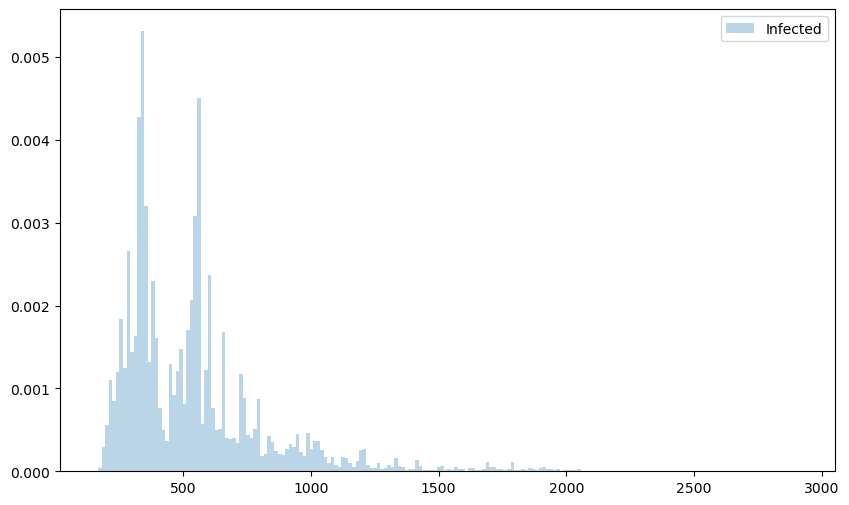

108139
108139
D3
best_edit_distance
[0]    112317
[1]     55351
Name: count, dtype: int64


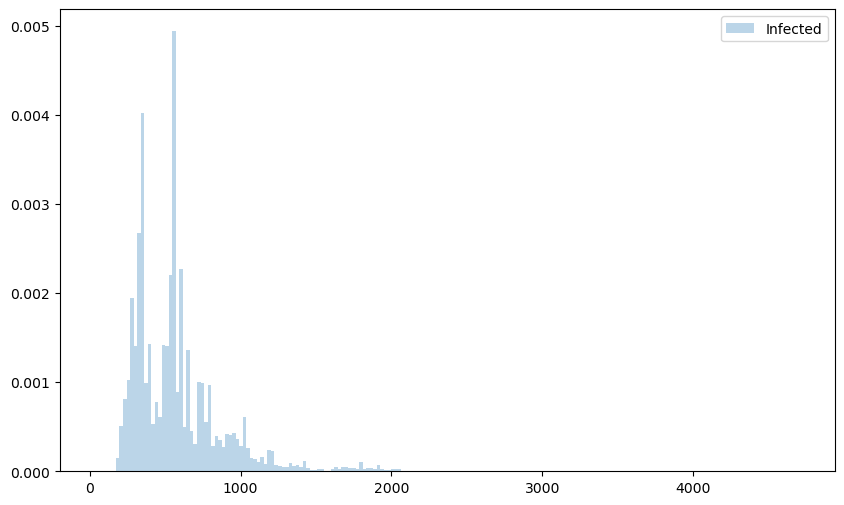

167668
167668
D7
best_edit_distance
[0]    91435
[1]    38092
Name: count, dtype: int64


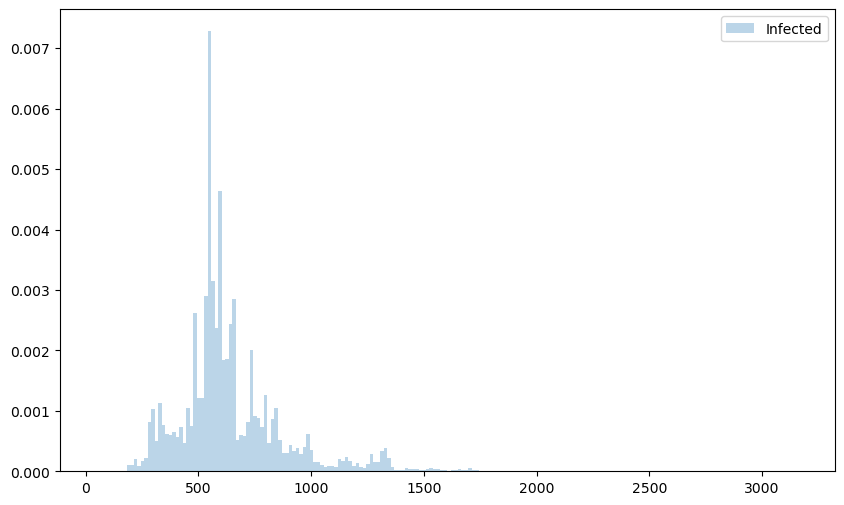

129527
129527
D10
best_edit_distance
[0]    209239
[1]     86262
Name: count, dtype: int64


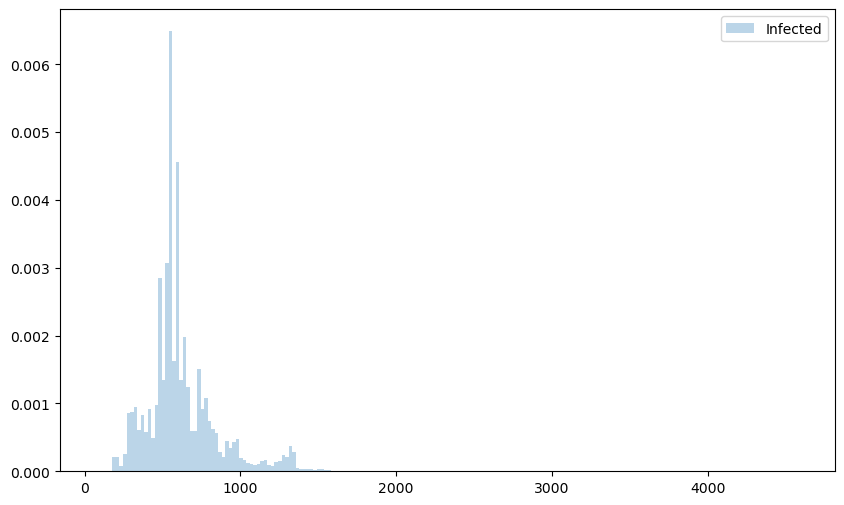

295501
295501
D14
best_edit_distance
[0]    115523
[1]     52940
Name: count, dtype: int64


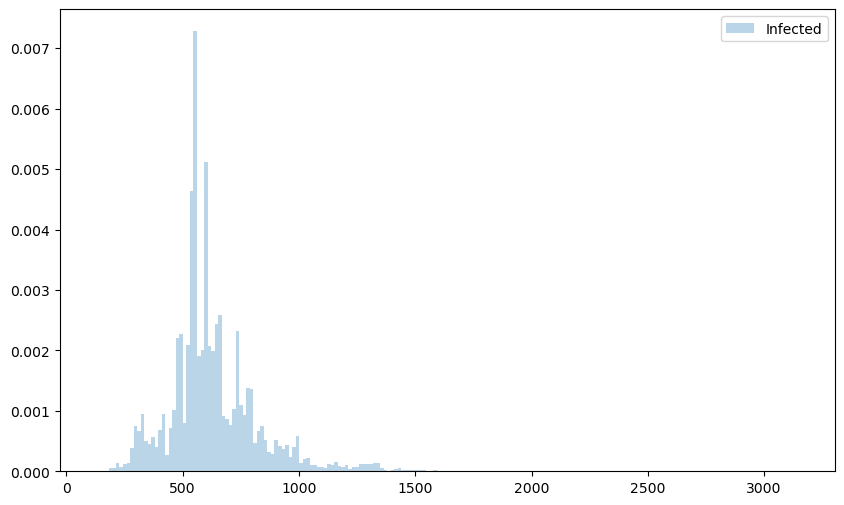

168463
168463
D21
best_edit_distance
[0]    82620
[1]    38849
Name: count, dtype: int64


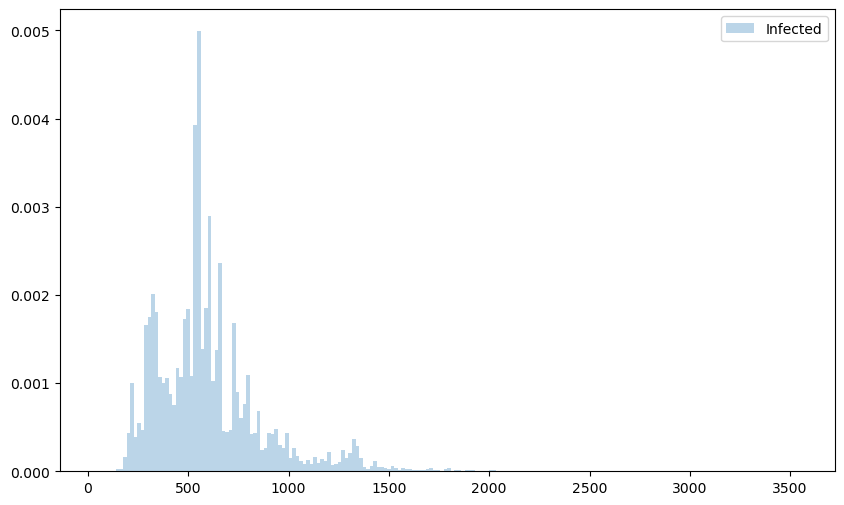

121469
121469


In [24]:
for tp in ['Mock','D3','D7','D10','D14','D21']:
# for tp in ['D7','D10','D14','D21']:

    print(tp)
    tmp_process_read_df = pd.read_pickle("../output_files/objects/"+tp+"_match_Barcode_process.pkl")
    # tmp_process_read_df = tmp_process_read_df[tmp_process_read_df['Ambiguity'] == "not"]
    tmp_process_read_df = tmp_process_read_df[tmp_process_read_df['adaptor_len'].isin([17,18,19])]
    tmp_process_read_df = tmp_process_read_df[tmp_process_read_df['best_edit_distance'].map(lambda d: len(d)==1)]
    tmp_process_read_df = tmp_process_read_df[tmp_process_read_df['best_edit_distance'].map(lambda d: d[0]<2)]    # allowing only 1 dist from the barcod
    print(tmp_process_read_df.best_edit_distance.value_counts(dropna=False))
    tmp_read_df = tmp_process_read_df.copy()
    tmp_read_df['linker'] = tmp_read_df.apply(lambda row: get_adaptor(row['seq'], row['raw_bc2_start'], row['adaptor_len']), axis=1)
    tmp_read_df[['BB2UMIVV','cDNA_polyA']] = tmp_read_df.apply(lambda row: get_cDNA(row['seq'], row['raw_bc2_start'], row['raw_bc2'], row['umi']), axis=1)
    tmp_read_df[['cDNA','polyA']] = tmp_read_df.apply(lambda row: extractPolyA(row['cDNA_polyA']), axis = 1)
    tmp_read_df['len_cDNA'] = tmp_read_df['cDNA'].str.len()
    # Plot histogram on length of cDNA
    plt.figure(figsize = (10,6))
    #plt.hist(ovp_mock_dmdf["len_cDNA"],bins = 200, alpha = 0.3, label = "Mock",density=True)
    plt.hist(tmp_read_df["len_cDNA"], bins = 200, alpha = 0.3, label = "Infected",density=True)
    plt.legend(loc="upper right")
    plt.show()
    tmp_read_df.index = range(0,tmp_read_df.shape[0])
    outFile = "../output_files/Mixcr_results/Mixcr_results_"+tp+"/"+tp
    out2=open(outFile+'_blaze_cDNA.fastq','w')
    for i in range(0,tmp_read_df.shape[0]):
        name = tmp_read_df.loc[i,"read_name"].replace(">","")
        # R1 = tmp_read_df.loc[i,"B1B2UMIVV"]
        # R2 = tmp_read_df.loc[i,"cDNA"][::-1]+tmp_read_df.loc[i,"polyA"]
        R2 = tmp_read_df.loc[i,"cDNA_polyA"]
        #R2 = ovp_inf_dmdf.loc[i,"cDNA"][::-1]
        out2.write('@'+name+'\n'+R2+'\n+\n'+'j'*len(R2)+'\n')
        # out1.write('@'+name+'\n'+R1+'\n+\n'+'j'*len(R1)+'\n')
    out2.close()
    # make list into string
    tmp_read_df['hit_barcode_num'] = tmp_read_df['bc_hit'].apply(len)
    tmp_read_df['hit_barcode_num'].value_counts(dropna=False)
    tmp_read_df['Barcode_hit'] = tmp_read_df['bc_hit'].apply(lambda x: x[0])
    print(tmp_read_df.shape[0])
    # get coordinate
    tmp_whitelist = pd.read_csv("../slideseq_beadbarcodes/"+tp+"_BeadBarcodes.txt", delimiter="\t", names= ["barcode", "x", "y"])
    tmp_read_df = pd.merge(tmp_read_df,tmp_whitelist,how='inner',left_on="Barcode_hit",right_on="barcode")
    print(tmp_read_df.shape[0])
    # to csv
    output_read_df = tmp_read_df[['id','seq','Sample','barcode','umi','x','y','best_edit_distance','len_cDNA']].copy()
    output_read_df.to_csv("../output_files/Mixcr_results/"+tp+"_demul_concensus_blaze_overlap_whitelist_1dis.csv",sep="\t",index=False)
    # original write out to pickle
    # tmp_read_df.to_pickle("../output_files/Mixcr_results/"+tp+"_match_Barcode_process_cleaned_1dis.pkl")